In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('./data/')
sys.path.append('./models/')
from thmodel import *
import pickle
with open('./data/dict_data_final.pkl', 'rb') as f:
    data = pickle.load(f)

# Datos $(x, y)$

In [2]:
x, y = data['Beneixama']

# Parámetros

In [3]:
list_P = [
    [0, 0.1, 0.5, 0.9, 1.01],
    [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01],
]

In [4]:
P = list_P[1]

# Resultados

In [5]:
grid = Grid(x=x, y=y, mode='gumbel')
grid.initialize(part=P)
grid.compute_th_param(grad=True)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

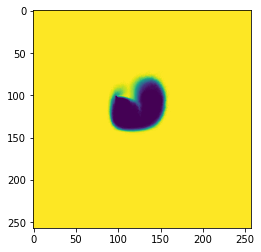

In [12]:
plt.imshow(grid.X0[:,:, -1].detach().numpy())

In [17]:
(grid.X0[:,:, -1].sum()).backward()

In [20]:
v = np.array([grid.alpha.grad.item(), grid.beta.grad.item(), grid.gamma.grad.item()])
v

array([ 270.9619751 , -331.10375977,  -82.54645538])

In [21]:
# normalize vector v
v = v / np.linalg.norm(v)